# ***Image Classification with a 2-layer network***

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from torch_gradient_computations import ComputeGradsWithTorch
import copy
import itertools

## 1) Training a multi-layer classifier

### Read in the data and initialize parameters

In [4]:
def read_batch(filename):
    """
    Reads in the data from a CIFAR-10 batch file and returns the image and label data in separate files.
    """
    # Load a batch of training data from filename
    cifar_dir = 'data/cifar-10-batches-py/'
    with open(cifar_dir + filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

    # Extract the image data and cast to float from the dict dictionary
    X = dict[b'data'].astype(np.float64) / 255.0

    # Transpose X so each column corresponds to an image
    X = X.transpose()

    # Extract the labels
    y = np.array(dict[b'labels'])

    # Perform one-hot encoding
    Y = np.zeros((10, X.shape[1]), dtype=np.float64)
    Y[y, np.arange(X.shape[1])] = 1

    return X, Y, y

def normalize(X, mean_X, std_X):
    """
    Normalize the data set with respect to the mean and standard deviation values from the training set.
    """
    X -= mean_X
    X /= std_X
    
    return X

def initialize_net(d=3072, K=10, L=2, m=50):
    """
    Initialize the network's parameters with standard Gaussian weights and zero biases for d-dimensional inputs, K-dimensional outputs and L layers of size m.
    """
    # Initialize the structure
    net_params = {}
    net_params['W'] = [None] * L
    net_params['b'] = [None] * L

    # Use a random BitGenerator
    rng = np.random.default_rng()
    BitGen = type(rng.bit_generator)
    seed = 42
    rng.bit_generator.state = BitGen(seed).state

    # From input
    net_params['W'][0] = 0.01*rng.standard_normal(size = (m, d))
    net_params['b'][0] = np.zeros((m, 1))

    # Between hidden layer(s)
    for l in range(1,L-1): # Starts at second layer and ends before the last one
        net_params['W'][l] = 0.01*rng.standard_normal(size = (m, m))
        net_params['b'][l] = np.zeros((m, 1))

    # To output layer
    net_params['W'][-1] = 0.01*rng.standard_normal(size = (K, m))
    net_params['b'][-1] = np.zeros((K, 1))
    
    return net_params

In [6]:
# Read in the data
X_train, Y_train, y_train = read_batch('data_batch_1')
X_val, Y_val, y_val = read_batch('data_batch_2')
X_test, Y_test, y_test = read_batch('test_batch')

# Pre-process the data
mean_X = np.mean(X_train, axis=1).reshape(X_train.shape[0], 1)
std_X = np.std(X_train, axis=1).reshape(X_train.shape[0], 1)
X_train = normalize(X_train, mean_X, std_X)
X_val = normalize(X_val, mean_X, std_X)
X_test = normalize(X_test, mean_X, std_X)

### Compute gradients for the network parameters

In [7]:
def ReLU(S):
    """
    Compute the ReLU function for a given input array S.
    """
    return np.maximum(0, S)
    
def softmax(S):
    """
    Compute the softmax function for a given input array S.
    """
    exp_S = np.exp(S)
    return exp_S / np.sum(exp_S, axis=0, keepdims=True)

def forward(X, network):
    """
    Apply the network function to multiple images and return both the outputs and the intermediary activation values.
    """
    W = network['W'] # Extract weights
    b = network['b'] # Extract biases
    L = len(W) # Number of layers
    fp_data = {} # Dictionary with hidden activations and output probabilities
    fp_data['h'] = [None] * (L-1) # Store the hidden activations for all hidden layers

    # From input
    S_l = np.dot(W[0], X) + b[0]

    # Hidden layers
    for l in range(L-1): # Iterate over hidden layers (ends at penultimate layer)
        fp_data['h'][l] = ReLU(S_l) # Activation values of the l-th hidden layer
        S_l = np.dot(W[l+1], fp_data['h'][l]) + b[l+1] # Compute next layer's input

    # Output layer
    fp_data['P'] = softmax(S_l) # Convert to probabilities
    
    return fp_data

def backward(X, Y, fp_data, network, lam):
    """
    Estimate, for a mini-batch, the gradients of the cost function with respect to weights and biases.
    """
    W = network['W'] # Extract weights
    b = network['b'] # Extract biases
    h = fp_data['h'] # Extract hidden activations
    P = fp_data['P'] # Extract output probabilities
    L = len(W) # Number of layers
    n_batch = X.shape[1]
    grads = {} # Dictionnary with the gradients
    grads['W'] = [None] * L
    grads['b'] = [None] * L

    # Backward pass
    G = - (Y - P)

    # Gradients for layers 2 to L
    for l in range(L-1, 0, -1):
        grads['W'][l] = np.dot(G,h[l-1].transpose()) / n_batch + 2 * lam * W[l]
        grads['b'][l] = np.sum(G, axis=1) / n_batch
        grads['b'][l] = grads['b'][l].reshape(-1, 1) # Add one dimension for computation convenience
        G = np.dot(W[l].transpose(),G)
        G = G * (h[l-1] > 0).astype(float)

    # Gradients for the first layer
    grads['W'][0] = np.dot(G, X.transpose()) / n_batch + 2 * lam * W[0]
    grads['b'][0] = np.sum(G, axis=1) / n_batch
    grads['b'][0] = grads['b'][0].reshape(-1, 1)

    return grads

In [7]:
# Initialize a small network for the checks
d_small = 10
n_small = 3
lam = 0
small_net = initialize_net(d=d_small, K=10, L=2, m=50)
X_small = X_train[0:d_small,0:n_small]
Y_small = Y_train[:,0:n_small]
fp_data = forward(X_small,small_net)
my_grads = backward(X_small,Y_small,fp_data,small_net,lam)
torch_grads=ComputeGradsWithTorch(X_small,y_train[0:n_small],small_net)

# Comparison
eps = 1e-8
min_error = float("inf")
max_error = float("-inf")
# Iterate over layers
for l, (w_a, b_a, w_n, b_n) in enumerate(zip(my_grads['W'], my_grads['b'], torch_grads['W'], torch_grads['b'])):
    print(f"\nLayer {l+1}:")
    
    # Errors on weight gradients
    abs_diff_w = np.abs(w_a - w_n)
    denominator_w = np.maximum(eps, np.abs(w_a) + np.abs(w_n))
    err_w = abs_diff_w / denominator_w
    min_err_w = np.min(err_w)
    max_err_w = np.max(err_w)
    print("Weights gradient errors:")
    print(f"Min weight error: {min_err_w}")
    print(f"Max weight error: {max_err_w}")

    # Errors on bias gradients
    abs_diff_b = np.abs(b_a - b_n)
    denominator_b = np.maximum(eps, np.abs(b_a) + np.abs(b_n))
    err_b = abs_diff_b / denominator_b
    min_err_b = np.min(err_b)
    max_err_b = np.max(err_b)
    print("Bias gradient errors:")
    print(f"Min bias error: {min_err_b}")
    print(f"Max bias error: {max_err_b}")


Layer 1:
Weights gradient errors:
Min weight error: 0.0
Max weight error: 4.845675541209772e-15
Bias gradient errors:
Min bias error: 0.0
Max bias error: 1.243288088465554e-15

Layer 2:
Weights gradient errors:
Min weight error: 0.0
Max weight error: 8.994132698236022e-15
Bias gradient errors:
Min bias error: 0.0
Max bias error: 1.388177914859e-16


### Train the network with a cyclic learning rates

In [10]:
def compute_loss(P, y):
    """
    Compute the mean cross-entropy loss of the network's predictions relative to the ground truth labels.
    """
    P_y = P[y, np.arange(P.shape[1])] # Extract the probabilitu=ies of the true labels
    return np.mean(-np.log(P_y))

def compute_accuracy(P, y):
    """
    Compute the accuracy of the network's predictions.
    """
    predicted_classes = np.argmax(P, axis=0)
    correct_predictions = np.sum(predicted_classes == y)  # Count correct predictions
    acc = correct_predictions / len(y) 
    return acc

def compute_cyclical_eta(t, n_s, eta_min, eta_max):
    """
    Compute the cyclical learning rate.
    """
    l = t // (2 * n_s)  # Compute the cycle indice l
    lower_bound = 2 * l * n_s
    upper_bound = (2 * l + 1) * n_s

    if lower_bound <= t < upper_bound:
        eta = eta_min + (t - lower_bound) * (eta_max - eta_min) / n_s
    else:
        eta = eta_max - (t - upper_bound) * (eta_max - eta_min) / n_s
    return eta

def minibatchGD(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng, plot_per=10, verbose=True, plot_learning=True, plot_eta=False):
    """
    Perform mini-batch gradient descent with cyclical learning rate.
    """
    n = X_train.shape[1] # Total number of samples
    n_batch, eta_min, eta_max, n_s, n_cycle = GDparams['n_batch'], GDparams['eta_min'], GDparams['eta_max'], GDparams['n_s'], GDparams['n_cycle']
    n_updates_total = 2 * n_s * n_cycle # Total number of updates
    n_updates_per_epoch = n // n_batch # Number of updates per epoch
    n_epoch = n_updates_total // n_updates_per_epoch # Number of epochs
    network =  copy.deepcopy(init_net) # Network initialization
   
    # Initialize tracking
    train_losses = []  # To store loss at every 10th update step
    train_accuracies = []  # To store accuracy at every 10th update step
    val_losses = []  # To store validation loss
    val_accuracies = []  # To store validation accuracy
    update_step = 0
    steps_plot = [] # To store update steps
    etas = [] # To store learning rates

    # Training loop
    for epoch in range(1, n_epoch + 1):  # One epoch = one full pass through the entire dataset
        # Shuffle the training instances before each epoch
        shuffled_indices = rng.permutation(n)  # Create a random permutation of indices
        X_shuffled = X_train[:, shuffled_indices]  # Apply the permutation to X
        Y_shuffled = Y_train[:, shuffled_indices]  # Apply the permutation to Y

        for j in range(n_updates_per_epoch):
            # Generate a random mini-batch of size n_batch
            j_start = j * n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            X_batch = X_shuffled[:, inds]
            Y_batch = Y_shuffled[:, inds]

            # Forward pass: compute hidden activations and probabilities for the batch samples
            fp_data_batch = forward(X_batch, network)

            # Backward pass: compute estimations of the gradient based on the batch samples
            grad_batch = backward(X_batch, Y_batch, fp_data_batch, network, lam)

            # Update parameters with cyclical learning rate for each layer separately
            update_step += 1  # Increment the update step counter
            eta = compute_cyclical_eta(update_step, n_s, eta_min, eta_max)
            etas.append(eta)
            for l in range(len(network['W'])):  # Iterate over layers
                network['W'][l] -= eta * grad_batch['W'][l]
                network['b'][l] -= eta * grad_batch['b'][l]

            # Compute losses and accuracies 10 times per cycle
            if update_step == 1 or update_step % (2 * n_s // plot_per) == 0 or update_step == n_updates_total:  # Track every 10th update step within a cycle
                # Compute training loss and accuracy
                P_train = forward(X_train, network)['P']
                train_loss = compute_loss(P_train, y_train)
                train_acc = compute_accuracy(P_train, y_train)

                # Append to the lists
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)
                steps_plot.append(update_step)

                # Compute validation loss and accuracy
                P_val = forward(X_val, network)['P']
                val_loss = compute_loss(P_val, y_val)
                val_acc = compute_accuracy(P_val, y_val)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

                if verbose:
                    print(f"Update step {update_step} || train_loss = {train_loss} || train_accuracy = {train_acc}")

    # Plotting the loss and accuracy over update steps
    if plot_learning:
        # Plot loss over update steps
        plt.plot(steps_plot, train_losses, label='Training Loss', color='g')
        plt.plot(steps_plot, val_losses, label='Validation Loss', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.savefig(f"loss_eta{eta}_lam{lam}_ncycle_{n_cycle}_ns_{n_s}.png", dpi=300)
        plt.show()

        # Plot accuracy over update steps
        plt.plot(steps_plot, train_accuracies, label='Training Accuracy', color='g')
        plt.plot(steps_plot, val_accuracies, label='Validation Accuracy', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.savefig(f"acc_eta{eta}_lam{lam}_ncycle_{n_cycle}_ns_{n_s}.png", dpi=300)
        plt.show()

    if plot_eta:
        # Plot learning rate
        plt.plot(np.arange(len(etas)), etas, label='Learning Rate', color='b')
        plt.xlabel('Update Steps')
        plt.ylabel('Learning rate')
        plt.legend()
        plt.grid()
        plt.savefig(f"lr_eta{eta}_lam{lam}_ncycle_{n_cycle}_ns_{n_s}.png", dpi=300)
        plt.show()

    return network

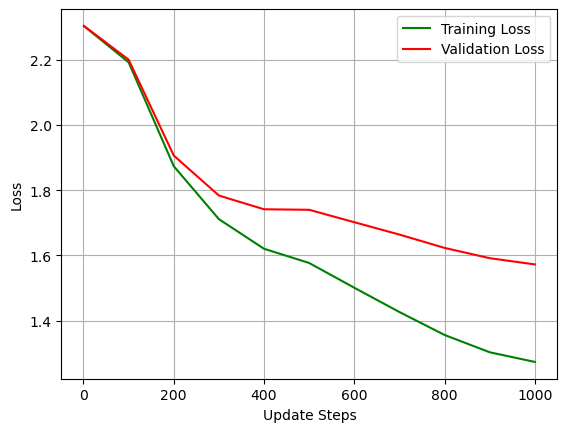

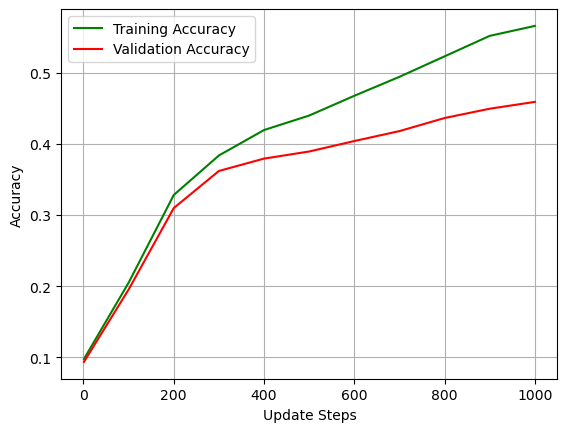

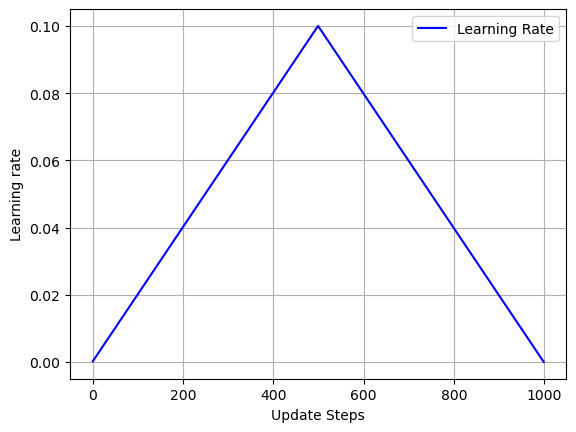


Training accuracy: 0.5662

Test accuracy: 0.4551


In [375]:
# Parameters
lam = 0.01
GDparams = {'n_batch': 100, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':500, 'n_cycle':1}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net()

# Training
network = minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, plot_per=10, verbose=False, plot_eta=True)

# Training accuracy
P = forward(X_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Test accuracy
P = forward(X_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

### Train the network for real

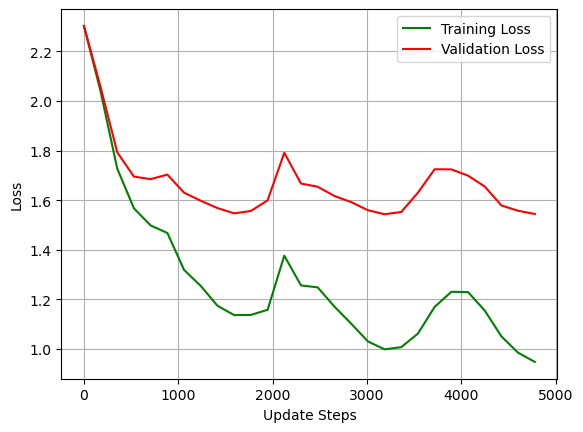

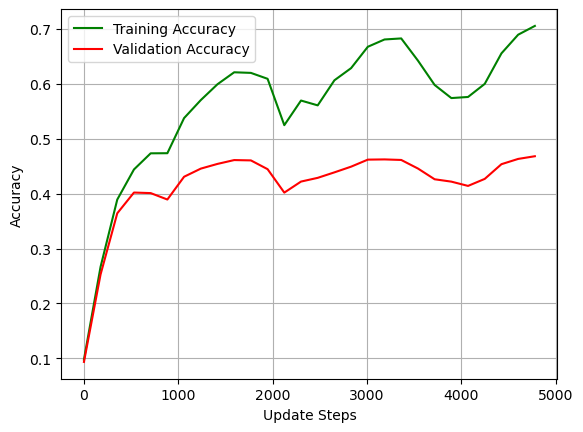

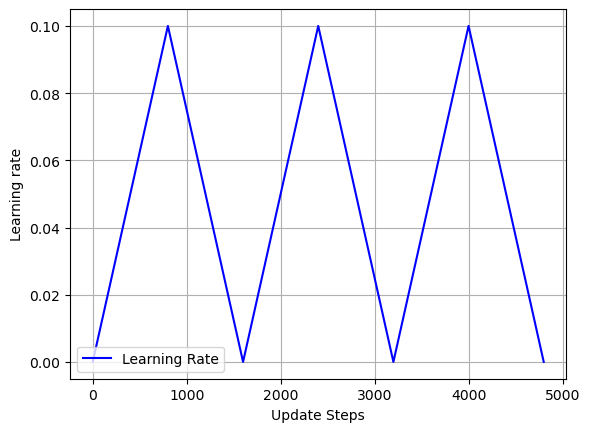


Training accuracy: 0.7067

Test accuracy: 0.4755


In [362]:
# Parameters
lam = 0.01
GDparams = {'n_batch': 100, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':800, 'n_cycle':3}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net()

# Training
network = minibatchGD(X_train, Y_train, y_train,  X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, plot_per=9, verbose=False, plot_eta=True)

# Training accuracy
P = forward(X_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Test accuracy
P = forward(X_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

### Coarse-to-fine random search to set lam

Data for param search:

In [14]:
# Read all the batches
X_1, Y_1, y_1 = read_batch('data_batch_1')
X_2, Y_2, y_2 = read_batch('data_batch_2')
X_3, Y_3, y_3 = read_batch('data_batch_3')
X_4, Y_4, y_4 = read_batch('data_batch_4')
X_5, Y_5, y_5 = read_batch('data_batch_5')
X_test_grid, Y_test_grid, y_test_grid = read_batch('test_batch')

# Concatenate them
X = np.hstack((X_1, X_2, X_3, X_4, X_5))
Y = np.hstack((Y_1, Y_2, Y_3, Y_4, Y_5))
y = np.hstack((y_1, y_2, y_3, y_4, y_5))

# Extract a validation set by randomly selecting 5000 samples
random_cols = np.random.choice(X.shape[1], size=5000, replace=False) # extract 5000 random column indices
X_train_grid, Y_train_grid, y_train_grid = np.delete(X, random_cols, axis=1), np.delete(Y, random_cols, axis=1), np.delete(y, random_cols) # keep the others for training
X_val_grid, Y_val_grid, y_val_grid = X[:, random_cols], Y[:, random_cols], y[random_cols] # extract 5000 random samples for validation

# Compute mean and std vectors from the training set
mean_X_grid = np.mean(X_train_grid, axis=1).reshape(X_train_grid.shape[0], 1)
std_X_grid = np.std(X_train_grid, axis=1).reshape(X_train_grid.shape[0], 1)

# Pre-processing with the new training set
X_train_grid = normalize(X_train_grid, mean_X_grid, std_X_grid)
X_val_grid = normalize(X_val_grid, mean_X_grid, std_X_grid)
X_test_grid = normalize(X_test_grid, mean_X_grid, std_X_grid)

Data for final test evaluations:

In [16]:
# Read all the batches
X_1, Y_1, y_1 = read_batch('data_batch_1')
X_2, Y_2, y_2 = read_batch('data_batch_2')
X_3, Y_3, y_3 = read_batch('data_batch_3')
X_4, Y_4, y_4 = read_batch('data_batch_4')
X_5, Y_5, y_5 = read_batch('data_batch_5')
X_test_2, Y_test_2, y_test_2 = read_batch('test_batch')

# Concatenate them
X = np.hstack((X_1, X_2, X_3, X_4, X_5))
Y = np.hstack((Y_1, Y_2, Y_3, Y_4, Y_5))
y = np.hstack((y_1, y_2, y_3, y_4, y_5))

# Use 49000 samples for training
random_cols = np.random.choice(X.shape[1], size=1000, replace=False) # extract 1000 random column indices
X_train_2, Y_train_2, y_train_2 = np.delete(X, random_cols, axis=1), np.delete(Y, random_cols, axis=1), np.delete(y, random_cols) # keep the others for training
X_val_2, Y_val_2, y_val_2 = X[:, random_cols], Y[:, random_cols], y[random_cols] # extract 1000 random samples for validation

# Compute mean and std vectors from the training set
mean_X_2 = np.mean(X_train_2, axis=1).reshape(X_train_2.shape[0], 1)
std_X_2 = np.std(X_train_2, axis=1).reshape(X_train_2.shape[0], 1)

# Pre-processing with the new training set
X_train_2 = normalize(X_train_2, mean_X_2, std_X_2)
X_val_2 = normalize(X_val_2, mean_X_2, std_X_2)
X_test_2 = normalize(X_test_2, mean_X_2, std_X_2)

Random search function:

In [55]:
def lam_random_search(X_train, Y_train, y_train, X_val, Y_val, y_val, y_test, n_lam, l_min, l_max, GDparams, rng):
    """
    Perform a random search over n_lam lambda values with other training parameters fixed.
    """
    res = {} # Dictionary to store the results
    
    for _ in range(n_lam):
        # Randomly select lambda
        l = l_min + (l_max - l_min) * rng.random()
        lam = 10 ** l

        # Initialize network
        init_net = initialize_net()

        # Training with the given lambda value
        network = minibatchGD(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False)
        
        # Store validation accuracy
        P = forward(X_val, network)['P']
        acc = compute_accuracy(P, y_val_2)
        res[lam] = acc

        # Print details
        print(f"\nTrained with lambda = {lam} | Validation accuracy = {acc}")

    return res

Coarse random search:

In [441]:
# Parameters
l_min = -5
l_max = -1
n_lam = 10 # Number of lambda values to be tested
n = X_train_2.shape[1]
n_batch = 100
n_s = int(2 * np.floor(n / n_batch))
GDparams = {'n_batch': n_batch, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':n_s, 'n_cycle':2}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net()

# Random search
res = lam_random_search(X_train_grid, Y_train_grid, y_train_grid, X_val_grid, Y_val_grid, y_val_grid, y_test_grid, n_lam, l_min, l_max, GDparams, rng)


Trained with lambda = 0.012468786659075639 | Validation accuracy = 0.4914

Trained with lambda = 0.00490102475708955 | Validation accuracy = 0.5092

Trained with lambda = 0.00010357315119180162 | Validation accuracy = 0.5038

Trained with lambda = 5.409173710682153e-05 | Validation accuracy = 0.5098

Trained with lambda = 0.0007549737105072431 | Validation accuracy = 0.5154

Trained with lambda = 0.01795728555245944 | Validation accuracy = 0.4844

Trained with lambda = 0.08066663024339923 | Validation accuracy = 0.401

Trained with lambda = 0.0007471256286723945 | Validation accuracy = 0.5104

Trained with lambda = 2.683658950418781e-05 | Validation accuracy = 0.5046

Trained with lambda = 2.587375896002884e-05 | Validation accuracy = 0.5084


Narrower search:

In [443]:
# Parameters
l_min = -5
l_max = -3
n_lam = 10 # Number of lambda values to be tested
n = X_train_2.shape[1]
n_batch = 100
n_s = int(2 * np.floor(n / n_batch))
GDparams = {'n_batch': n_batch, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':n_s, 'n_cycle':3}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net()

# Random search
res = lam_random_search(X_train_grid, Y_train_grid, y_train_grid, X_val_grid, Y_val_grid, y_val_grid, y_test_grid, n_lam, l_min, l_max, GDparams, rng)


Trained with lambda = 0.00035311169138214097 | Validation accuracy = 0.512

Trained with lambda = 0.00032481197799643616 | Validation accuracy = 0.5142

Trained with lambda = 2.3257630383773306e-05 | Validation accuracy = 0.5042

Trained with lambda = 0.0003340977498287872 | Validation accuracy = 0.5038

Trained with lambda = 0.000898146036251339 | Validation accuracy = 0.5154

Trained with lambda = 4.847434745672646e-05 | Validation accuracy = 0.5102

Trained with lambda = 1.608532217893965e-05 | Validation accuracy = 0.518

Trained with lambda = 7.32015816762109e-05 | Validation accuracy = 0.5108

Trained with lambda = 5.718063969588827e-05 | Validation accuracy = 0.5098

Trained with lambda = 0.0001105072240583061 | Validation accuracy = 0.5108


Final model evaluation:

Update step 1 || train_loss = 2.3025989946711536 || train_accuracy = 0.09597777777777777
Update step 180 || train_loss = 2.0648348746790184 || train_accuracy = 0.26195555555555555
Update step 360 || train_loss = 1.7718709068063982 || train_accuracy = 0.3708
Update step 540 || train_loss = 1.670269610014004 || train_accuracy = 0.40444444444444444
Update step 720 || train_loss = 1.5710615162545873 || train_accuracy = 0.4430222222222222
Update step 900 || train_loss = 1.5746992063283234 || train_accuracy = 0.44451111111111113
Update step 1080 || train_loss = 1.5358497909702287 || train_accuracy = 0.4490222222222222
Update step 1260 || train_loss = 1.4076885188207122 || train_accuracy = 0.5036666666666667
Update step 1440 || train_loss = 1.3741833732311217 || train_accuracy = 0.5189111111111111
Update step 1620 || train_loss = 1.3337993906126866 || train_accuracy = 0.5340222222222222
Update step 1800 || train_loss = 1.3045531897475044 || train_accuracy = 0.5452444444444444
Update step 1980

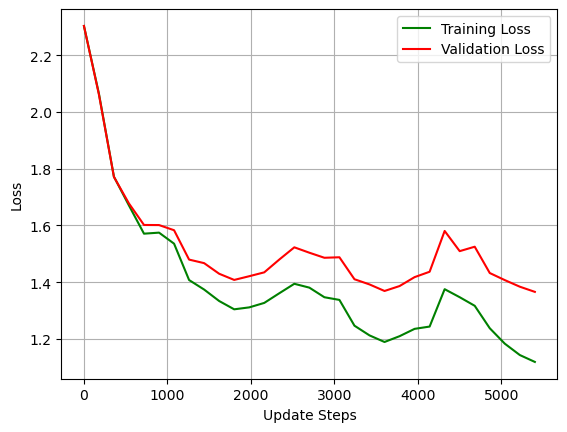

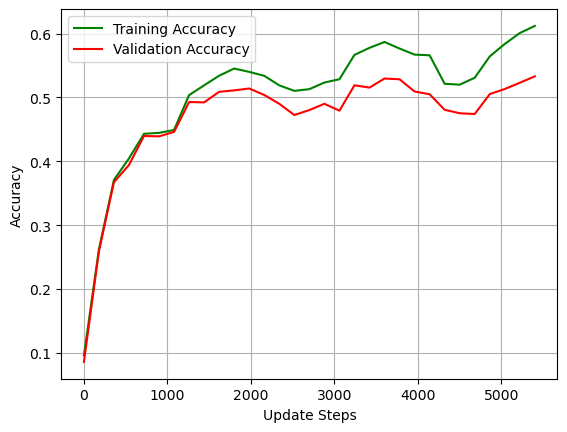


Training accuracy: 0.6119555555555556

Test accuracy: 0.5116


In [176]:
# Parameters
lam = 1.6085e-05 # Get the better lambda that we found
GDparams = {'n_batch': 100, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':900, 'n_cycle':3}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net()

# Training
network = minibatchGD(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng)

# Training accuracy
P = forward(X_train_2, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_2))

# Test accuracy
P = forward(X_test_2, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test_2))

## 2) Extensions

### Performance improvement

In [27]:
def forward_dropout(X, network, p=1, mode='testing', rng=None):
    """
    Apply the network function with dropout to multiple images and return both the outputs and the intermediary activation values.
    """
    W = network['W'] # Extract weights
    b = network['b'] # Extract biases
    L = len(W) # Number of layers
    fp_data = {} # Dictionary with hidden activations and output probabilities
    fp_data['h'] = [None] * (L-1) # Store the hidden activations for all hidden layers

    # From input
    S_l = np.dot(W[0], X) + b[0]

    # Hidden layers
    for l in range(L-1): # Iterate over hidden layers (ends at penultimate layer)
        fp_data['h'][l] = ReLU(S_l) # Activation values of the l-th hidden layer
        if mode == 'training': # Inverted dropout: scale the activations during training
            mask_l = (rng.random(size=np.shape(X[0])) < p) / p
            fp_data['h'][l] *= mask_l
        S_l = np.dot(W[l+1], fp_data['h'][l]) + b[l+1] # Compute next layer's input

    # Output layer
    fp_data['P'] = softmax(S_l) # Convert to probabilities
    
    return fp_data

def pre_compute_flip_indices():
    """
    Pre-compute the flip indices for the images.
    """
    aa = np.int32(np.arange(32)).reshape((32, 1))
    bb = np.int32(np.arange(31, -1, -1)).reshape((32, 1))
    vv = np.tile(32 * aa, (1, 32))
    
    ind_flip = vv.reshape((32 * 32, 1)) + np.tile(bb, (32, 1))
    inds_flip = np.vstack((ind_flip, 1024 + ind_flip))
    inds_flip = np.vstack((inds_flip, 2048 + ind_flip))
    
    return inds_flip

def pre_compute_shift_indices():
    """
    Pre-compute the shift indices for all (tx, ty) pairs where tx, ty are integers between -3 and +3.
    """
    original_size = 32
    indices_dict = {} 
    for tx in range(-3, 4):
        for ty in range(-3, 4):
            original_indices = []
            new_indices = []
            for channel in range(3): # Iterate over all the dimensions on the image
                for i in range(32):
                    for j in range(32):
                        new_i = i + tx
                        new_j = j + ty
        
                        if 0 <= new_i < 32 and 0 <= new_j < 32:
                            original_index = i + 32 * j + channel * 1024
                            new_index = new_i + 32 * new_j + channel * 1024
        
                            original_indices.append(original_index)
                            new_indices.append(new_index)
        
            original, new = np.array(original_indices).reshape(-1, 1), np.array(new_indices).reshape(-1, 1)

            indices_dict[(tx,ty)] = (original, new)

    return indices_dict

def minibatchGD_improved(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng, eta_decay_factor=None, plot_per=10, verbose=True, plot_learning=True, plot_eta=False, data_augmentation=False):
    """
    Perform mini-batch gradient descent with linearly decayed cyclical learning rate, data augmentation and dropout.
    """
    n = X_train.shape[1] # Total number of samples
    n_batch, eta_min, eta_max, n_s, n_cycle, p = GDparams['n_batch'], GDparams['eta_min'], GDparams['eta_max'], GDparams['n_s'], GDparams['n_cycle'], GDparams['dropout_rate']
    n_updates_total = 2 * n_s * n_cycle # Total number of updates
    n_updates_per_epoch = n // n_batch # Number of updates per epoch
    n_epoch = n_updates_total // n_updates_per_epoch # Number of epochs
    network =  copy.deepcopy(init_net) # Network initialization
   
    # Initialize tracking
    train_losses = []  # To store loss at every 10th update step
    train_accuracies = []  # To store accuracy at every 10th update step
    val_losses = []  # To store validation loss
    val_accuracies = []  # To store validation accuracy
    update_step = 0
    steps_plot = [] # To store update steps
    etas = [] # To store learning rates

    if data_augmentation:
        # Precompute flip and shift indices
        inds_flip = pre_compute_flip_indices()
        inds_shift = pre_compute_shift_indices()
    
    for epoch in range(1, n_epoch + 1):
        # Shuffle the training instances before each epoch
        shuffled_indices = rng.permutation(n)
        X_shuffled = X_train[:, shuffled_indices]
        Y_shuffled = Y_train[:, shuffled_indices]

        if data_augmentation:
            # Generate masks and translation values for all batch samples
            flip_mask = rng.random(n_batch) > 0.5 # Flip mask with probability 0.5
            shift_mask = rng.random(n_batch) > 0.5 # Shift mask with probability 0.5
            tx_vals = rng.integers(-3, 4, size=n_batch) # Generate random tx values for all batch samples
            ty_vals = rng.integers(-3, 4, size=n_batch) # Generate random ty values for all batch samples

        for j in range(n_updates_per_epoch):
            # Generate a random mini-batch of size n_batch
            j_start = j * n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            X_batch = X_shuffled[:, inds]
            Y_batch = Y_shuffled[:, inds]

            if data_augmentation:
                # Randomly flip and shift some samples
                for i in range(n_batch):
                    if flip_mask[i]:
                        X_batch[:, i] = X_batch[:, i][inds_flip].flatten()
                    if shift_mask[i]:
                        tx, ty = tx_vals[i], ty_vals[i]
                        indsfill, indsxx = inds_shift[(tx, ty)] # Indices associated with the given t values
                        X_batch[:,i][indsfill] = X_batch[:,i][indsxx]

            # Forward pass: compute hidden activations and probabilities for the batch samples
            fp_data_batch = forward_dropout(X_batch, network, p=p, mode='training', rng=rng)

            # Backward pass: compute estimations of the gradient based on the batch samples
            grad_batch = backward(X_batch, Y_batch, fp_data_batch, network, lam)
            
            # Update parameters with cyclical learning rate for each layer separately
            update_step += 1  # Increment the update step counter
            # Learning rate annealing
            if eta_decay_factor != None and update_step % (2 * n_s) == 0: # If a cycle has been achived
                eta_max *= eta_decay_factor
            eta = compute_cyclical_eta(update_step, n_s, eta_min, eta_max)
            etas.append(eta)
            for l in range(len(network['W'])):  # Iterate over layers
                network['W'][l] -= eta * grad_batch['W'][l]
                network['b'][l] -= eta * grad_batch['b'][l]

            # Compute losses and accuracies 10 times per cycle
            if update_step == 1 or update_step % (2 * n_s // plot_per) == 0 or update_step == n_updates_total:  # Track every 10th update step within a cycle
                # Compute training loss and accuracy
                P_train = forward_dropout(X_train, network)['P']
                train_loss = compute_loss(P_train, y_train)
                train_acc = compute_accuracy(P_train, y_train)
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)

                # Compute validation loss and accuracy
                P_val = forward_dropout(X_val, network)['P']
                val_loss = compute_loss(P_val, y_val)
                val_acc = compute_accuracy(P_val, y_val)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                steps_plot.append(update_step)

                if verbose:
                    print(f"Update step {update_step} || train_loss = {train_loss} || train_accuracy = {train_acc}")

    if plot_learning:
        # Plot loss over update steps
        plt.plot(steps_plot, train_losses, label='Training Loss', color='g')
        plt.plot(steps_plot, val_losses, label='Validation Loss', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.savefig(f"loss_annealing_dropout{p}_eta{eta}_lam{lam}_ncycle_{n_cycle}_ns_{n_s}.png", dpi=300)
        plt.show()

        # Plot accuracy over update steps
        plt.plot(steps_plot, train_accuracies, label='Training Accuracy', color='g')
        plt.plot(steps_plot, val_accuracies, label='Validation Accuracy', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.savefig(f"acc_annealing_dropout{p}_eta{eta}_lam{lam}_ncycle_{n_cycle}_ns_{n_s}.png", dpi=300)
        plt.show()

    if plot_eta:
        # Plot learning rate
        plt.plot(np.arange(len(etas)), etas, label='Learning Rate', color='b')
        plt.xlabel('Update Steps')
        plt.ylabel('Learning rate')
        plt.legend()
        plt.grid()
        plt.savefig(f"lr_annealing_dropout{p}_eta{eta}_lam{lam}_ncycle_{n_cycle}_ns_{n_s}.png", dpi=300)
        plt.show()

    return network

a) Increase the number of hidden nodes

Update step 1 || train_loss = 2.303651581504336 || train_accuracy = 0.10497777777777778
Update step 180 || train_loss = 1.998186113164431 || train_accuracy = 0.30064444444444444
Update step 360 || train_loss = 1.7288429785739932 || train_accuracy = 0.38715555555555553
Update step 540 || train_loss = 1.6187598520320414 || train_accuracy = 0.4246888888888889
Update step 720 || train_loss = 1.5683058760104849 || train_accuracy = 0.43875555555555557
Update step 900 || train_loss = 1.5402046060012589 || train_accuracy = 0.454
Update step 1080 || train_loss = 1.4393445931913225 || train_accuracy = 0.49804444444444446
Update step 1260 || train_loss = 1.3910199946887896 || train_accuracy = 0.5160222222222223
Update step 1440 || train_loss = 1.3141652061445375 || train_accuracy = 0.5390444444444444
Update step 1620 || train_loss = 1.2577381935743566 || train_accuracy = 0.5645555555555556
Update step 1800 || train_loss = 1.2281494920600313 || train_accuracy = 0.5799333333333333
Update step 1980 

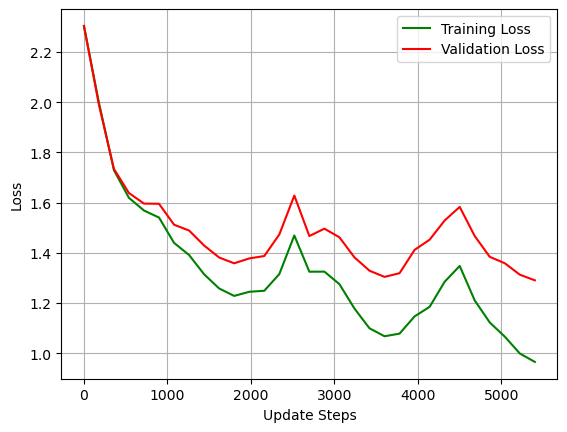

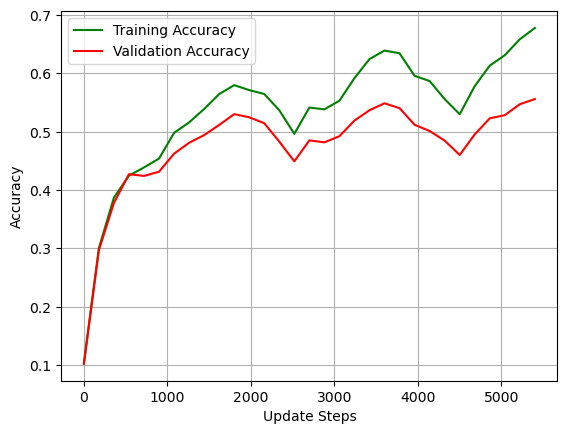


Training accuracy: 0.6780444444444444

Validation accuracy: 0.556

Test accuracy: 0.541


In [40]:
n_nodes, lam = 150, 0.001
GDparams = {'n_batch': 100, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':900, 'n_cycle':3, 'dropout_rate':1}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net(m=n_nodes)

# Training
network = minibatchGD_improved(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng)

# Training accuracy
P = forward_dropout(X_train_2, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_2))

# Validation accuracy
P = forward_dropout(X_val_2, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val_2))

# Test accuracy
P = forward_dropout(X_test_2, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test_2))

b) Apply dropout

Update step 1 || train_loss = 2.3036512245454195 || train_accuracy = 0.105
Update step 180 || train_loss = 2.037641338711885 || train_accuracy = 0.29546666666666666
Update step 360 || train_loss = 1.7783081319008418 || train_accuracy = 0.38251111111111114
Update step 540 || train_loss = 1.6580326374139223 || train_accuracy = 0.42233333333333334
Update step 720 || train_loss = 1.5864256122819849 || train_accuracy = 0.4446
Update step 900 || train_loss = 1.5913942894076298 || train_accuracy = 0.4307111111111111
Update step 1080 || train_loss = 1.5212187569236781 || train_accuracy = 0.47073333333333334
Update step 1260 || train_loss = 1.4589320075039478 || train_accuracy = 0.4942666666666667
Update step 1440 || train_loss = 1.383443071132871 || train_accuracy = 0.5223555555555556
Update step 1620 || train_loss = 1.3341742686037292 || train_accuracy = 0.5489333333333334
Update step 1800 || train_loss = 1.3122581863051133 || train_accuracy = 0.5639777777777778
Update step 1980 || train_loss

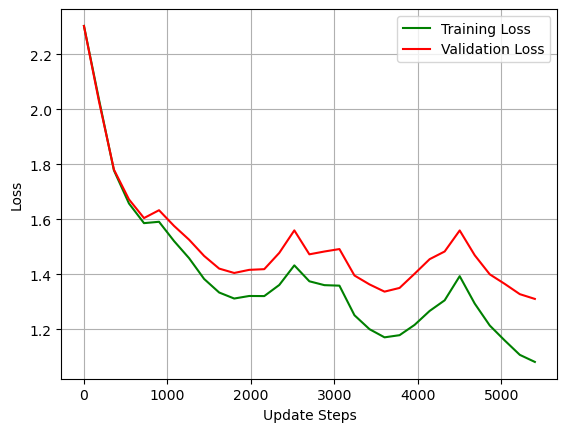

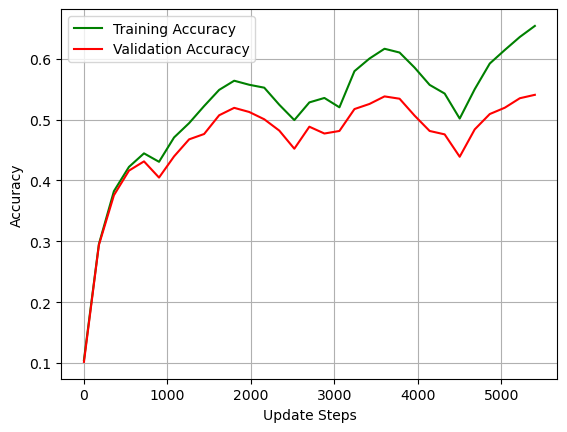


Training accuracy: 0.6540444444444444

Validation accuracy: 0.5408

Test accuracy: 0.5352


In [42]:
n_nodes, lam = 150, 0.001
GDparams = {'n_batch': 100, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':900, 'n_cycle':3, 'dropout_rate':0.8}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net(m=n_nodes)

# Training
network = minibatchGD_improved(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng)

# Training accuracy
P = forward_dropout(X_train_2, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_2))

# Validation accuracy
P = forward_dropout(X_val_2, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val_2))

# Test accuracy
P = forward_dropout(X_test_2, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test_2))

c) Data augmentation

Update step 1 || train_loss = 2.303654711412087 || train_accuracy = 0.10502222222222223
Update step 180 || train_loss = 2.0473693762309297 || train_accuracy = 0.2961111111111111
Update step 360 || train_loss = 1.7961223065259695 || train_accuracy = 0.3762
Update step 540 || train_loss = 1.6828236750734482 || train_accuracy = 0.41184444444444446
Update step 720 || train_loss = 1.6533138556416813 || train_accuracy = 0.4255555555555556
Update step 900 || train_loss = 1.632884853551918 || train_accuracy = 0.41784444444444446
Update step 1080 || train_loss = 1.5496546233915707 || train_accuracy = 0.4537555555555556
Update step 1260 || train_loss = 1.4951238301897347 || train_accuracy = 0.4792444444444444
Update step 1440 || train_loss = 1.4528088286541438 || train_accuracy = 0.5009777777777777
Update step 1620 || train_loss = 1.4217129301755085 || train_accuracy = 0.5176666666666667
Update step 1800 || train_loss = 1.4027337637233448 || train_accuracy = 0.5285111111111112
Update step 1980 |

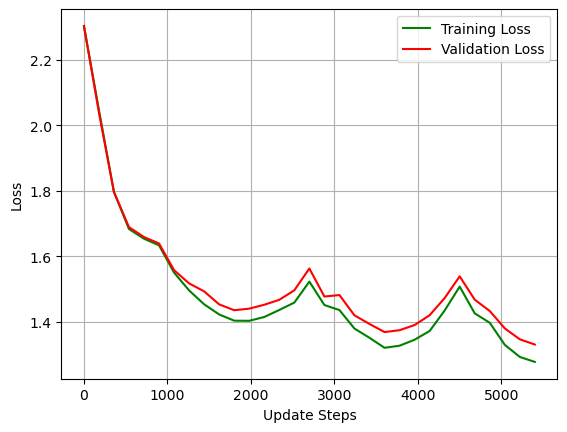

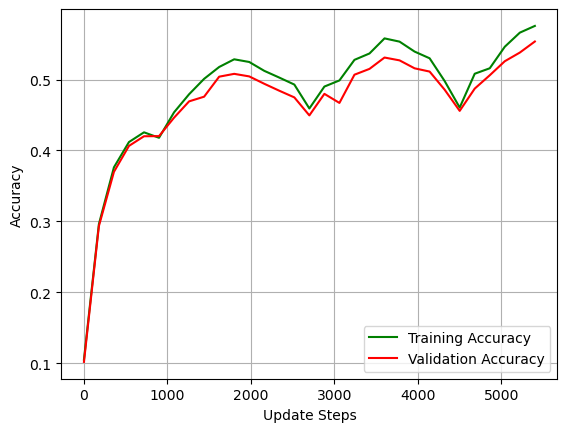


Training accuracy: 0.5755777777777777

Validation accuracy: 0.5536

Test accuracy: 0.5501


In [44]:
n_nodes, lam = 150, 0.001
GDparams = {'n_batch': 100, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':900, 'n_cycle':3, 'dropout_rate':0.8}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net(m=n_nodes)

# Training
network = minibatchGD_improved(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng, data_augmentation=True)

# Training accuracy
P = forward_dropout(X_train_2, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_2))

# Validation accuracy
P = forward_dropout(X_val_2, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val_2))

# Test accuracy
P = forward_dropout(X_test_2, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test_2))

### Best possible accuracy

In [239]:
def grid_search(X_train, Y_train, y_train, X_val, Y_val, y_val, param_grid, rng):
    """
    Perform grid search over specified hyperparameters and return the best model.
    """
    best_net = None
    best_acc = 0
    best_params = None
    
    # Get all possible combinations of hyperparameters
    param_combinations = list(itertools.product(*param_grid.values()))
    
    for params in param_combinations:
        # Extract parameters
        m, lam, n_batch, eta_min, eta_max, eta_decay_factor, n_s, n_cycle, dropout_rate = params
        GDparams = {'n_batch': n_batch, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle, 'dropout_rate':dropout_rate}

        # Initialize network with the right architecture
        init_net = initialize_net(m=m)
        
        # Training
        print(f"Training with params: eta_decay_factor={eta_decay_factor}, lam={lam}, dropout_rate={dropout_rate}, n_cycle={n_cycle}")
        network = minibatchGD_improved(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, eta_decay_factor=eta_decay_factor, verbose=False, plot_learning=False, data_augmentation=True)
        
        # Compute validation accuracy
        P = forward_dropout(X_val, network)['P']
        val_acc = compute_accuracy(P, y_val)
        print(f"Validation accuracy: {val_acc:.4f}\n")
        
        # Update best network if validation accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = network
            best_params = params
    
    print("Best parameters:", best_params)
    
    return best_net, best_params, best_acc

In [243]:
# Define hyperparameter search space
param_grid = {
    'n_nodes': [150], 
    'lam': [0.0001, 0.001],
    'n_batch': [100],
    'eta_min': [1e-5],
    'eta_max': [1e-1],
    'eta_decay_factor': [0.8, 1.0],
    'n_s': [900],
    'n_cycle': [5, 7, 9],
    'dropout_rate': [0.8, 1.0]
}

rng = np.random.default_rng(seed=42)

# Perform grid search
best_net, best_params, best_val_acc = grid_search(X_train_grid, Y_train_grid, y_train_grid, X_val_grid, Y_val_grid, y_val_grid, param_grid, rng)

Training with params: eta_decay_factor=0.8, lam=0.0001, dropout_rate=0.8, n_cycle=7
Validation accuracy: 0.5670

Training with params: eta_decay_factor=0.8, lam=0.0001, dropout_rate=1.0, n_cycle=7
Validation accuracy: 0.5734

Training with params: eta_decay_factor=0.8, lam=0.0001, dropout_rate=0.8, n_cycle=9
Validation accuracy: 0.5786

Training with params: eta_decay_factor=0.8, lam=0.0001, dropout_rate=1.0, n_cycle=9
Validation accuracy: 0.5806

Training with params: eta_decay_factor=1.0, lam=0.0001, dropout_rate=0.8, n_cycle=7
Validation accuracy: 0.5686

Training with params: eta_decay_factor=1.0, lam=0.0001, dropout_rate=1.0, n_cycle=7
Validation accuracy: 0.5758

Training with params: eta_decay_factor=1.0, lam=0.0001, dropout_rate=0.8, n_cycle=9
Validation accuracy: 0.5736

Training with params: eta_decay_factor=1.0, lam=0.0001, dropout_rate=1.0, n_cycle=9
Validation accuracy: 0.5828

Training with params: eta_decay_factor=0.8, lam=0.001, dropout_rate=0.8, n_cycle=7
Validation ac

Final test evaluation:

Update step 1 || train_loss = 2.303591364533593 || train_accuracy = 0.10471111111111112
Update step 180 || train_loss = 2.0051715449747722 || train_accuracy = 0.28735555555555553
Update step 360 || train_loss = 1.7441822404517957 || train_accuracy = 0.383
Update step 540 || train_loss = 1.6479182970177007 || train_accuracy = 0.4186
Update step 720 || train_loss = 1.592769158667057 || train_accuracy = 0.4344
Update step 900 || train_loss = 1.6001494147176485 || train_accuracy = 0.4388222222222222
Update step 1080 || train_loss = 1.53739860040609 || train_accuracy = 0.4507111111111111
Update step 1260 || train_loss = 1.4485188691166353 || train_accuracy = 0.4928222222222222
Update step 1440 || train_loss = 1.3969968119055003 || train_accuracy = 0.5108444444444444
Update step 1620 || train_loss = 1.3545278265542136 || train_accuracy = 0.5255111111111112
Update step 1800 || train_loss = 1.3315398186377234 || train_accuracy = 0.5405333333333333
Update step 1980 || train_loss = 1.33646048227

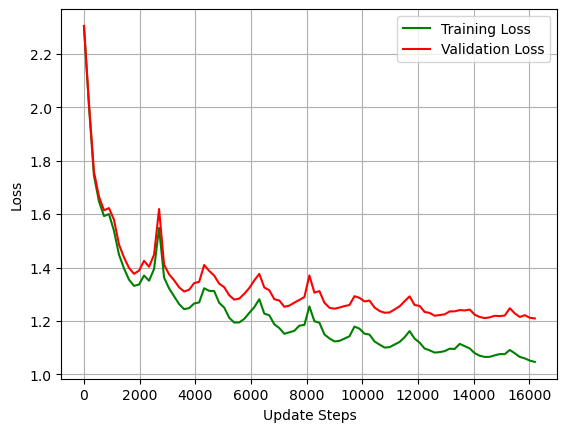

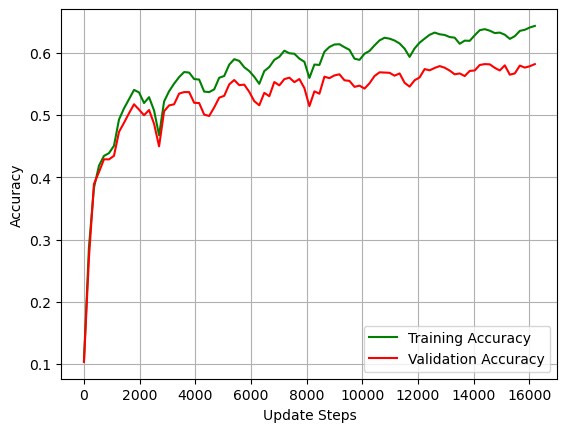


Training accuracy: 0.6433777777777778

Validation accuracy: 0.582

Test accuracy: 0.5769


In [250]:
# Best parameters from the grid search
n_nodes, lam = 150, 0.001
GDparams = {'n_batch': 100, 'eta_min': 1e-5, 'eta_max':1e-1, 'n_s':900, 'n_cycle':9, 'dropout_rate':1}
eta_decay_factor = 0.8
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net(m=n_nodes)

# Training
network = minibatchGD_improved(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng, eta_decay_factor=eta_decay_factor, data_augmentation=True)

# Training accuracy
P = forward_dropout(X_train_2, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_2))

# Validation accuracy
P = forward_dropout(X_val_2, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val_2))

# Test accuracy
P = forward_dropout(X_test_2, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test_2))

### Best possible accuracy with Adam optimizer

In [59]:
def minibatchGD_Adam(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng, plot_per=100, verbose=True, plot_learning=True, plot_eta=False, data_augmentation=False):
    """
    Perform mini-batch gradient descent with Adam optimizer, data augmentation and dropout.
    """
    n = X_train.shape[1] # Total number of samples
    n_batch, eta, n_epoch, p, beta_1, beta_2 = GDparams['n_batch'], GDparams['eta'], GDparams['n_epoch'], GDparams['dropout_rate'], GDparams['beta_1'], GDparams['beta_2']
    n_updates_total = n_epoch * n // n_batch
    network =  copy.deepcopy(init_net) # Network initialization

    # Initialize Adam optimizer parameters
    eps = 1e-8
    m_W = [np.zeros_like(w) for w in network['W']]  # First moment (mean of gradients)
    v_W = [np.zeros_like(w) for w in network['W']]  # Second moment (variance of gradients)
    m_b = [np.zeros_like(b) for b in network['b']]  # First moment (mean of gradients)
    v_b = [np.zeros_like(b) for b in network['b']]  # Second moment (variance of gradients)
   
    # Initialize tracking
    train_losses = []  # To store loss at every 10th update step
    train_accuracies = []  # To store accuracy at every 10th update step
    val_losses = []  # To store validation loss
    val_accuracies = []  # To store validation accuracy
    update_step = 0
    steps_plot = [] # To store update steps

    if data_augmentation:
        # Precompute flip and shift indices
        inds_flip = pre_compute_flip_indices()
        inds_shift = pre_compute_shift_indices()
    
    for epoch in range(1, n_epoch + 1):
        # Shuffle the training instances before each epoch
        shuffled_indices = rng.permutation(n)
        X_shuffled = X_train[:, shuffled_indices]
        Y_shuffled = Y_train[:, shuffled_indices]

        if data_augmentation:
            # Generate masks and translation values for all batch samples
            flip_mask = rng.random(n_batch) > 0.5 # Flip mask with probability 0.5
            shift_mask = rng.random(n_batch) > 0.5 # Shift mask with probability 0.5
            tx_vals = rng.integers(-3, 4, size=n_batch) # Generate random tx values for all batch samples
            ty_vals = rng.integers(-3, 4, size=n_batch) # Generate random ty values for all batch samples

        for j in range(n // n_batch):
            # Generate a random mini-batch of size n_batch
            j_start = j * n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            X_batch = X_shuffled[:, inds]
            Y_batch = Y_shuffled[:, inds]

            if data_augmentation:
                # Randomly flip and shift some samples
                for i in range(n_batch):
                    if flip_mask[i]:
                        X_batch[:, i] = X_batch[:, i][inds_flip].flatten()
                    if shift_mask[i]:
                        tx, ty = tx_vals[i], ty_vals[i]
                        indsfill, indsxx = inds_shift[(tx, ty)] # Indices associated with the given t values
                        X_batch[:,i][indsfill] = X_batch[:,i][indsxx]

            # Forward pass: compute hidden activations and probabilities for the batch samples
            fp_data_batch = forward_dropout(X_batch, network, p=p, mode='training', rng=rng)

            # Backward pass: compute estimations of the gradient based on the batch samples
            grad_batch = backward(X_batch, Y_batch, fp_data_batch, network, lam)
            
            # Update parameters with cyclical learning rate for each layer separately
            update_step += 1  # Increment the update step counter
            
            for l in range(len(network['W'])):  # Iterate over layers
                # Compute averages of gradients
                m_W[l] = beta_1 * m_W[l] + (1 - beta_1) * grad_batch['W'][l]
                v_W[l] = beta_2 * v_W[l] + (1 - beta_2) * (grad_batch['W'][l] ** 2)
                m_b[l] = beta_1 * m_b[l] + (1 - beta_1) * grad_batch['b'][l]
                v_b[l] = beta_2 * v_b[l] + (1 - beta_2) * (grad_batch['b'][l] ** 2)

                # Bias correction
                m_W_hat = m_W[l] / (1 - beta_1 ** update_step)
                v_W_hat = v_W[l] / (1 - beta_2 ** update_step)
                m_b_hat = m_b[l] / (1 - beta_1 ** update_step)
                v_b_hat = v_b[l] / (1 - beta_2 ** update_step)

                # Update parameters
                network['W'][l] -= eta * m_W_hat / (np.sqrt(v_W_hat) + eps)
                network['b'][l] -= eta * m_b_hat / (np.sqrt(v_b_hat) + eps)
                
            # Compute losses and accuracies 10 times per cycle
            if update_step == 1 or update_step % plot_per == 0 or update_step == n_updates_total:  # Track every 10th update step within a cycle
                # Compute training loss and accuracy
                P_train = forward_dropout(X_train, network)['P']
                train_loss = compute_loss(P_train, y_train)
                train_acc = compute_accuracy(P_train, y_train)
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)

                # Compute validation loss and accuracy
                P_val = forward_dropout(X_val, network)['P']
                val_loss = compute_loss(P_val, y_val)
                val_acc = compute_accuracy(P_val, y_val)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                steps_plot.append(update_step)

                if verbose:
                    print(f"Update step {update_step} || train_loss = {train_loss} || train_accuracy = {train_acc}")

    if plot_learning:
        # Plot loss over update steps
        plt.plot(steps_plot, train_losses, label='Training Loss', color='g')
        plt.plot(steps_plot, val_losses, label='Validation Loss', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.savefig(f"loss_Adam_dropout{p}_eta{eta}_lam{lam}_nepoch{n_epoch}.png", dpi=300)
        plt.show()

        # Plot accuracy over update steps
        plt.plot(steps_plot, train_accuracies, label='Training Accuracy', color='g')
        plt.plot(steps_plot, val_accuracies, label='Validation Accuracy', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.savefig(f"acc_Adam_dropout{p}_eta{eta}_lam{lam}_n_epoch{n_epoch}.png", dpi=300)
        plt.show()

    if plot_eta:
        # Plot learning rate
        plt.plot(np.arange(len(etas)), etas, label='Learning Rate', color='b')
        plt.xlabel('Update Steps')
        plt.ylabel('Learning rate')
        plt.legend()
        plt.grid()
        plt.savefig(f"lr_Adam_dropout{p}_eta{eta}_lam{lam}_n_epoch{n_epoch}.png", dpi=300)
        plt.show()

    return network

def grid_search_Adam(X_train, Y_train, y_train, X_val, Y_val, y_val, param_grid, rng):
    """
    Perform grid search for Adam optimizer over specified hyperparameters and return the best model.
    """
    best_net = None
    best_acc = 0
    best_params = None
    
    # Get all possible combinations of hyperparameters
    param_combinations = list(itertools.product(*param_grid.values()))
    
    for params in param_combinations:
        # Extract parameters
        n_batch, m, lam, n_epoch, eta, beta_1, beta_2, dropout_rate = params
        GDparams = {'n_batch': n_batch, 'eta': eta, 'n_epoch':n_epoch,'dropout_rate':dropout_rate, 'beta_1':beta_1, 'beta_2': beta_2}

        # Initialize network with the right architecture
        init_net = initialize_net(m=m)
        
        # Training
        print(f"Training with params: lam={lam}, dropout_rate={dropout_rate}, n_epoch={n_epoch}")
        network = minibatchGD_Adam(X_train, Y_train, y_train, X_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False, data_augmentation=True)
        
        # Compute validation accuracy
        P = forward_dropout(X_val, network)['P']
        val_acc = compute_accuracy(P, y_val)
        print(f"Validation accuracy: {val_acc:.4f}\n")
        
        # Update best network if validation accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_net = network
            best_params = params
    
    print("Best parameters:", best_params)
    
    return best_net, best_params, best_acc

In [63]:
# Define hyperparameter search space
param_grid = {
    'n_batch': [100],
    'n_nodes': [150], 
    'lam': [0.0001, 0.001],
    'n_epoch': [15, 20, 30],
    'eta': [0.001],
    'beta_1': [0.9],
    'beta_2': [0.999],
    'dropout_rate': [0.8, 1.0]
}

rng = np.random.default_rng(seed=42)

# Perform grid search
best_net, best_params, best_val_acc = grid_search_Adam(X_train_grid, Y_train_grid, y_train_grid, X_val_grid, Y_val_grid, y_val_grid, param_grid, rng)

Training with params: lam=0.0001, dropout_rate=0.8, n_epoch=15
Validation accuracy: 0.5134

Training with params: lam=0.0001, dropout_rate=1.0, n_epoch=15
Validation accuracy: 0.5254

Training with params: lam=0.0001, dropout_rate=0.8, n_epoch=20
Validation accuracy: 0.5098

Training with params: lam=0.0001, dropout_rate=1.0, n_epoch=20
Validation accuracy: 0.5424

Training with params: lam=0.001, dropout_rate=0.8, n_epoch=15
Validation accuracy: 0.4746

Training with params: lam=0.001, dropout_rate=1.0, n_epoch=15
Validation accuracy: 0.4884

Training with params: lam=0.001, dropout_rate=0.8, n_epoch=20
Validation accuracy: 0.4780

Training with params: lam=0.001, dropout_rate=1.0, n_epoch=20
Validation accuracy: 0.5028

Best parameters: (100, 150, 0.0001, 20, 0.001, 0.9, 0.999, 1.0)


Final test evaluation:

Update step 1 || train_loss = 2.294441464288535 || train_accuracy = 0.15208888888888888
Update step 100 || train_loss = 1.9121824571688197 || train_accuracy = 0.3332222222222222
Update step 200 || train_loss = 1.7949384307426872 || train_accuracy = 0.37193333333333334
Update step 300 || train_loss = 1.7335348686806993 || train_accuracy = 0.396
Update step 400 || train_loss = 1.6875856105897877 || train_accuracy = 0.41057777777777776
Update step 500 || train_loss = 1.6567736092936467 || train_accuracy = 0.42062222222222223
Update step 600 || train_loss = 1.6321899146741143 || train_accuracy = 0.42766666666666664
Update step 700 || train_loss = 1.6078335571120843 || train_accuracy = 0.4342
Update step 800 || train_loss = 1.5889882020677766 || train_accuracy = 0.44464444444444445
Update step 900 || train_loss = 1.57322685586531 || train_accuracy = 0.4497333333333333
Update step 1000 || train_loss = 1.557110449550546 || train_accuracy = 0.4567111111111111
Update step 1100 || train_loss = 1

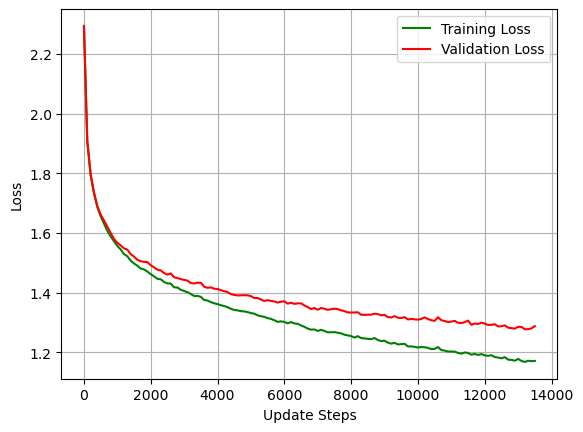

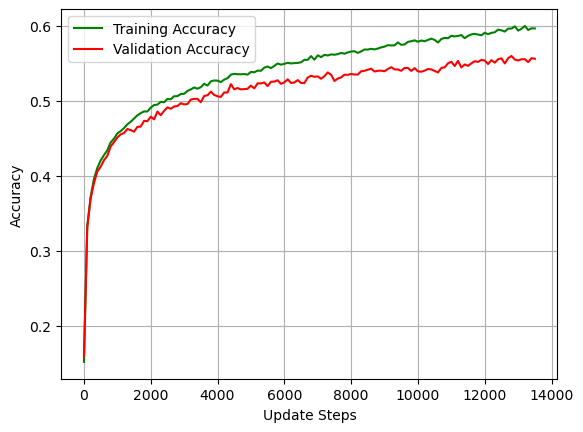


Training accuracy: 0.5966444444444444

Validation accuracy: 0.5562

Test accuracy: 0.5505


In [67]:
# Best parameters from grid search
n_nodes, lam = 150, 0.0001
GDparams = {'n_batch': 100, 'eta': 0.0001, 'n_epoch':30, 'dropout_rate':1, 'beta_1':0.9, 'beta_2':0.999}
rng = np.random.default_rng(seed=42)

# Initialize network
init_net = initialize_net(m=n_nodes)

# Training
network = minibatchGD_Adam(X_train_2, Y_train_2, y_train_2,  X_val_2, Y_val_2, y_val_2, GDparams, init_net, lam, rng=rng, data_augmentation=True)

# Training accuracy
P = forward_dropout(X_train_2, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_2))

# Validation accuracy
P = forward_dropout(X_val_2, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val_2))

# Test accuracy
P = forward_dropout(X_test_2, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test_2))